## Exploratory Data Analysis 

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from scipy.stats import ttest_ind
from IPython.display import display


### Load Data

In [71]:
# Load the data
gen1_train = pd.read_csv("gen1_train_comp_final.csv")  #parents
gen2_train = pd.read_csv("gen2_train_comp_final.csv")  #children



print("Gen 1 Data:")
print(gen1_train.head())
print("\nGen 2 Data:")
print(gen2_train.head())

Gen 1 Data:
   gen1_id sex_assigned_at_birth   age    SHgt_cm
0      774                     F  0.10  56.961812
1      774                     F  0.25  64.826190
2      774                     F  0.50  74.340764
3      774                     F  0.75  79.747338
4      774                     F  1.00  84.092569

Gen 2 Data:
   gen2_id sex_assigned_at_birth study_parent_sex  study_parent_id_new  AgeGr  \
0     3012                     M           mother                  636   0.10   
1     3012                     M           mother                  636   0.25   
2     3012                     M           mother                  636   0.50   
3     3012                     M           mother                  636   0.75   
4     3012                     M           mother                  636   1.00   

     SHgt_cm    Wgt_kg  
0  56.251625  4.636903  
1  64.491579       NaN  
2  70.465927       NaN  
3  73.992677       NaN  
4  79.343537       NaN  


### Checking the missing value
- Only numerical value (height and weight) has missing values

In [72]:
# Check for missing values (training data)
print("\nMissing values in Gen 1:")
print(gen1_train.isnull().sum())
print("\nMissing values in Gen 2:")
print(gen2_train.isnull().sum())


Missing values in Gen 1:
gen1_id                    0
sex_assigned_at_birth      0
age                        0
SHgt_cm                  310
dtype: int64

Missing values in Gen 2:
gen2_id                     0
sex_assigned_at_birth       0
study_parent_sex            0
study_parent_id_new         0
AgeGr                       0
SHgt_cm                   512
Wgt_kg                   2045
dtype: int64


### Mismatch in parent sex for some subjects
- Fix the mismatch manually

In [73]:
gen2_train.loc[gen2_train['gen2_id'].isin([1332, 2505]), 'study_parent_sex'] = 0
gen2_train.loc[gen2_train['gen2_id'].isin([2517, 3012]), 'study_parent_sex'] = 1

### Preprocess Gen1 data

In [74]:
gen1_train['age'] = gen1_train['age'].round().astype(int)
gen1_train = gen1_train.groupby(['gen1_id', 'sex_assigned_at_birth', 'age'], as_index=False).mean()
gen1_train = gen1_train.sort_values(by=['gen1_id', 'age'])
gen1_train['SHgt_cm'] = gen1_train.groupby('gen1_id')['SHgt_cm'].apply(lambda x: x.interpolate(method="linear")).bfill().values
gen1_train['sex_assigned_at_birth'] = gen1_train['sex_assigned_at_birth'].map({'F': 0, 'M': 1})

# Compute parent growth velocity
gen1_train['growth_velocity_parent'] = gen1_train.groupby('gen1_id')['SHgt_cm'].diff() / gen1_train.groupby('gen1_id')['age'].diff()

# Aggregate parent growth statistics
parent_features = gen1_train.groupby('gen1_id').agg(
    SHgt_cm_mean=('SHgt_cm', 'mean'),
    SHgt_cm_max=('SHgt_cm', 'max'),
    SHgt_cm_min=('SHgt_cm', 'min'),
    SHgt_cm_std=('SHgt_cm', 'std'),
    growth_velocity_parent_mean=('growth_velocity_parent', 'mean'),
    growth_velocity_parent_max=('growth_velocity_parent', 'max'),
    growth_velocity_parent_min=('growth_velocity_parent', 'min'),
    growth_velocity_parent_std=('growth_velocity_parent', 'std'),
    sex_assigned_at_birth=('sex_assigned_at_birth', 'first')  # Include parent sex
).reset_index()

### Preprocess Gen2 data

In [75]:
# Preprocess Gen2 data
gen2_train['AgeGr'] = gen2_train['AgeGr'].round().astype(int)
gen2_train = gen2_train.groupby(['gen2_id', 'sex_assigned_at_birth', 'study_parent_sex', 'study_parent_id_new', 'AgeGr'], as_index=False).mean()
gen2_train = gen2_train.sort_values(by=['gen2_id', 'AgeGr'])
gen2_train['SHgt_cm'] = gen2_train.groupby('gen2_id')['SHgt_cm'].apply(lambda x: x.interpolate(method="linear")).bfill().values
gen2_train['Wgt_kg'] = gen2_train.groupby('gen2_id')['Wgt_kg'].apply(lambda x: x.interpolate(method="linear")).bfill().values
gen2_train['sex_assigned_at_birth'] = gen2_train['sex_assigned_at_birth'].map({'F': 0, 'M': 1})
gen2_train['study_parent_sex'] = gen2_train['study_parent_sex'].map({'mother': 0, 'father': 1}).fillna(-1).astype(int)

In [76]:
# Manual correction of study_parent_sex values
gen2_train.loc[gen2_train['gen2_id'].isin([1332, 2505]), 'study_parent_sex'] = 0  # Assigning 'mother'
gen2_train.loc[gen2_train['gen2_id'].isin([2517, 3012]), 'study_parent_sex'] = 1  # Assigning 'father'

# Compute child growth velocity
gen2_train['growth_velocity_child'] = gen2_train.groupby('gen2_id')['SHgt_cm'].diff() / gen2_train.groupby('gen2_id')['AgeGr'].diff()

# Compute pubertal growth spurt magnitude (max velocity during puberty)
gen2_train['pubertal_growth_spurt_magnitude'] = gen2_train.groupby('gen2_id')['growth_velocity_child'].transform('max')

# Aggregate child features
child_features = gen2_train.groupby('gen2_id').agg(
    final_height=('SHgt_cm', 'max'),
    pubertal_growth_spurt_magnitude=('pubertal_growth_spurt_magnitude', 'max'),
    study_parent_id=('study_parent_id_new', 'first'),
    sex_assigned_at_birth=('sex_assigned_at_birth', 'first'),  # Include child sex
    study_parent_sex=('study_parent_sex', 'first')  # Include parent sex
).reset_index()

In [77]:
print("\nMissing values in Gen 1:")
print(gen1_train.isnull().sum())
print("\nMissing values in Gen 2:")
print(gen2_train.isnull().sum())


Missing values in Gen 1:
gen1_id                     0
sex_assigned_at_birth       0
age                         0
SHgt_cm                     0
growth_velocity_parent    101
dtype: int64

Missing values in Gen 2:
gen2_id                              0
sex_assigned_at_birth                0
study_parent_sex                     0
study_parent_id_new                  0
AgeGr                                0
SHgt_cm                              0
Wgt_kg                               0
growth_velocity_child              192
pubertal_growth_spurt_magnitude      0
dtype: int64


In [78]:
missing_count = gen2_train['study_parent_sex'].isna().sum()
print(f"Number of gen2_id without study_parent_sex: {missing_count}")

Number of gen2_id without study_parent_sex: 0


In [79]:
missing_gen2_ids = gen2_train.loc[gen2_train['study_parent_sex']== -1, 'gen2_id'].unique()
print("Unique gen2_id values without study_parent_sex:")
print(missing_gen2_ids)

Unique gen2_id values without study_parent_sex:
[]


In [80]:
# Remove rows where 'study_parent_sex' is NaN
gen2_train = gen2_train[gen2_train['study_parent_sex'] != -1]

### Merge Child and Parent Data

In [81]:
merged_data = child_features.merge(parent_features, left_on='study_parent_id', right_on='gen1_id', how='left')

# ---- Rename Sex Columns for Clarity ----
merged_data = merged_data.rename(columns={
    'sex_assigned_at_birth_x': 'child_sex',
    'sex_assigned_at_birth_y': 'parent_sex'
})

In [82]:
merged_data

,gen2_id,final_height,pubertal_growth_spurt_magnitude,study_parent_id,child_sex,study_parent_sex,gen1_id,SHgt_cm_mean,SHgt_cm_max,SHgt_cm_min,SHgt_cm_std,growth_velocity_parent_mean,growth_velocity_parent_max,growth_velocity_parent_min,growth_velocity_parent_std,parent_sex
0,1332,160.222405,14.613603,724,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2330,131.799105,10.934223,262,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2331,171.815312,14.799765,274,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2505,150.663565,13.071671,668,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2507,164.874826,14.248875,350,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,2825,135.400949,16.306865,570,1,0,570.0,135.352285,169.941494,61.114234,34.960455,5.423511,13.993414,-0.357047,4.261349,0.0
188,2827,174.151818,12.710090,744,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189,2829,168.980405,15.299155,662,0,1,662.0,136.009255,177.561546,62.517168,36.552568,5.750473,13.754115,-0.478630,3.951935,1.0
190,2830,159.909045,14.128323,712,0,0,712.0,132.850583,166.097378,60.394801,34.241379,5.283373,15.571050,-0.220142,4.276738,0.0


In [83]:
# Check for rows where gen1_id (from parent_features) is missing in the merged DataFrame
missing_gen1_id_rows = merged_data[merged_data['gen1_id'].isna()]

# Display the count and gen2_id values with missing gen1_id
print(f"Number of rows with missing gen1_id: {missing_gen1_id_rows.shape[0]}")
print("Unique gen2_id values without matching gen1_id:")
print(missing_gen1_id_rows['gen2_id'].unique())

Number of rows with missing gen1_id: 41
Unique gen2_id values without matching gen1_id:
[1332 2330 2331 2505 2507 2512 2534 2543 2551 2558 2562 2575 2583 2586
 2600 2601 2611 2614 2616 2624 2632 2633 2635 2645 2648 2651 2669 2682
 2684 2685 2701 2702 2704 2709 2727 2734 2777 2802 2803 2806 2827]


### Model for Predicting Final Height

In [84]:
# ---- Model for Predicting Final Height ----
X_final_height = merged_data[['study_parent_sex',
                              'SHgt_cm_mean', 'SHgt_cm_max', 'SHgt_cm_min', 'SHgt_cm_std', 
                              'growth_velocity_parent_mean', 'growth_velocity_parent_max', 
                              'growth_velocity_parent_min', 'growth_velocity_parent_std']]
y_final_height = merged_data['final_height']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_final_height, y_final_height, test_size=0.2, random_state=42)

# Train Random Forest model
model_final_height = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=2, min_samples_leaf=2, n_jobs=-1, random_state=42)
model_final_height.fit(X_train, y_train)

# Evaluate model
y_pred = model_final_height.predict(X_test)
rmse_final_height = np.sqrt(mean_squared_error(y_test, y_pred))

# Feature importance
importances_final_height = model_final_height.feature_importances_
feature_names = X_final_height.columns
feature_importance_final_height_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances_final_height}).sort_values(by='Importance', ascending=False)

In [85]:
print(y_final_height.describe())

count    192.000000
mean     167.039512
std       23.345603
min       62.963392
25%      164.764058
50%      171.634602
75%      178.086051
max      196.140713
Name: final_height, dtype: float64


In [86]:
from sklearn.preprocessing import StandardScaler

# Normalize the target variable
scaler = StandardScaler()
y_final_height_scaled = scaler.fit_transform(y_final_height.values.reshape(-1, 1)).flatten()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_final_height, y_final_height_scaled, test_size=0.2, random_state=42)

# Train the model
model_final_height = RandomForestRegressor(n_estimators=500, max_depth=15, min_samples_split=2, min_samples_leaf=2, n_jobs=-1, random_state=42)
model_final_height.fit(X_train, y_train)

# Evaluate the model
y_pred_scaled = model_final_height.predict(X_test)
mse = mean_squared_error(y_test, y_pred_scaled)
print(f'Mean Squared Error for Final Height Prediction (Scaled): {mse}')

# Inverse transform to get predictions in the original scale
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
mse_original = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), y_pred)
print(f'Mean Squared Error for Final Height Prediction (Original Scale): {mse_original}')

Mean Squared Error for Final Height Prediction (Scaled): 1.1696638030794728
Mean Squared Error for Final Height Prediction (Original Scale): 634.1666425025198


In [87]:
y_train_pred = model_final_height.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
print(f'Training MSE: {mse_train}')
print(f'Test MSE: {mse}')

Training MSE: 0.5003615912599195
Test MSE: 1.1696638030794728


In [88]:
print("Root Mean Squared Error for Final Height Prediction:", rmse_final_height)
print("\nFeature Importance for Final Height Prediction:")
print(feature_importance_final_height_df)

Root Mean Squared Error for Final Height Prediction: 25.061893300183343

Feature Importance for Final Height Prediction:
                       Feature  Importance
7   growth_velocity_parent_min    0.332793
1                 SHgt_cm_mean    0.183574
3                  SHgt_cm_min    0.107732
8   growth_velocity_parent_std    0.100089
4                  SHgt_cm_std    0.080323
2                  SHgt_cm_max    0.062478
6   growth_velocity_parent_max    0.053329
5  growth_velocity_parent_mean    0.048994
0             study_parent_sex    0.030688


### Model for Predicting Pubertal Growth Spurt Magnitude

In [89]:
X_pubertal_growth = merged_data[['study_parent_sex',
                                 'SHgt_cm_mean', 'SHgt_cm_max', 'SHgt_cm_min', 'SHgt_cm_std', 
                                 'growth_velocity_parent_mean', 'growth_velocity_parent_max', 
                                 'growth_velocity_parent_min', 'growth_velocity_parent_std']]
y_pubertal_growth = merged_data['pubertal_growth_spurt_magnitude']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_pubertal_growth, y_pubertal_growth, test_size=0.2, random_state=42)

# Train Random Forest model
model_pubertal_growth = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=2, min_samples_leaf=2, n_jobs=-1, random_state=42)
model_pubertal_growth.fit(X_train, y_train)

# Evaluate model
y_pred = model_pubertal_growth.predict(X_test)
rmse_pubertal_growth = np.sqrt(mean_squared_error(y_test, y_pred))

# Feature importance
importances_pubertal_growth = model_pubertal_growth.feature_importances_
feature_importance_pubertal_growth_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances_pubertal_growth}).sort_values(by='Importance', ascending=False)


In [90]:
print("\nRoot Mean Squared Error for Pubertal Growth Spurt Prediction:", rmse_pubertal_growth)
print("\nFeature Importance for Pubertal Growth Spurt Prediction:")
print(feature_importance_pubertal_growth_df)


Root Mean Squared Error for Pubertal Growth Spurt Prediction: 2.9770280861358445

Feature Importance for Pubertal Growth Spurt Prediction:
                       Feature  Importance
7   growth_velocity_parent_min    0.276845
6   growth_velocity_parent_max    0.161281
8   growth_velocity_parent_std    0.149737
1                 SHgt_cm_mean    0.105824
3                  SHgt_cm_min    0.098798
4                  SHgt_cm_std    0.088151
5  growth_velocity_parent_mean    0.054416
2                  SHgt_cm_max    0.040543
0             study_parent_sex    0.024405


### Graphs

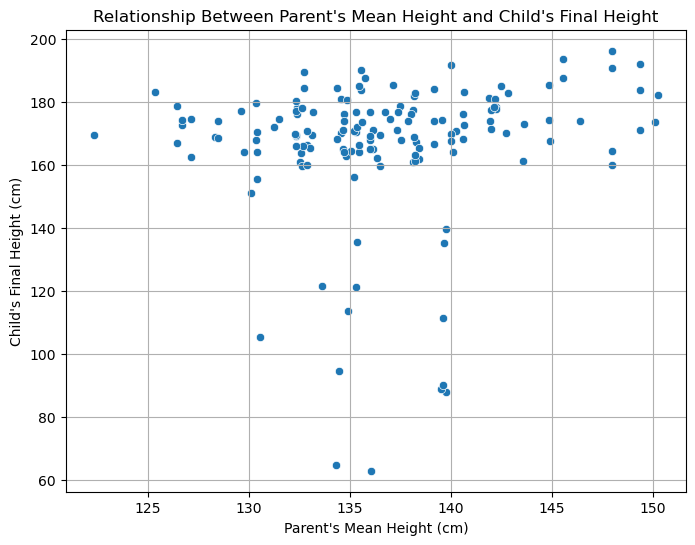

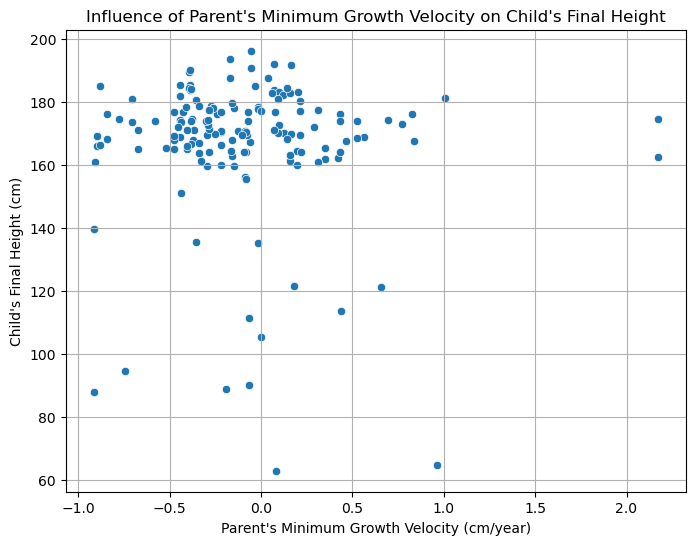

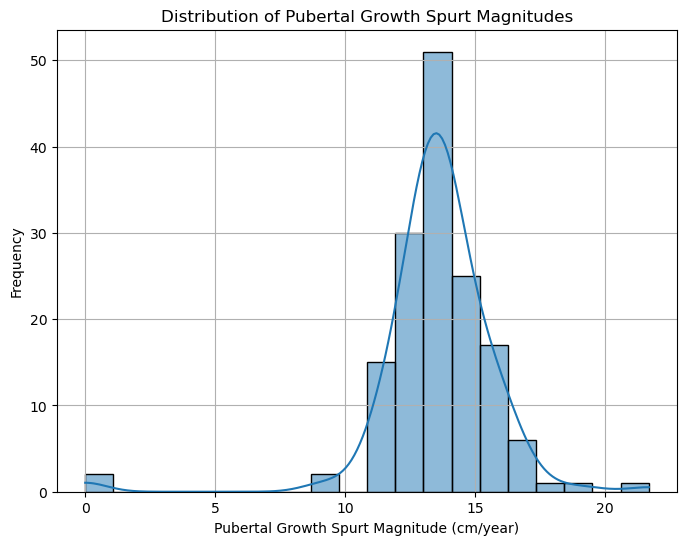

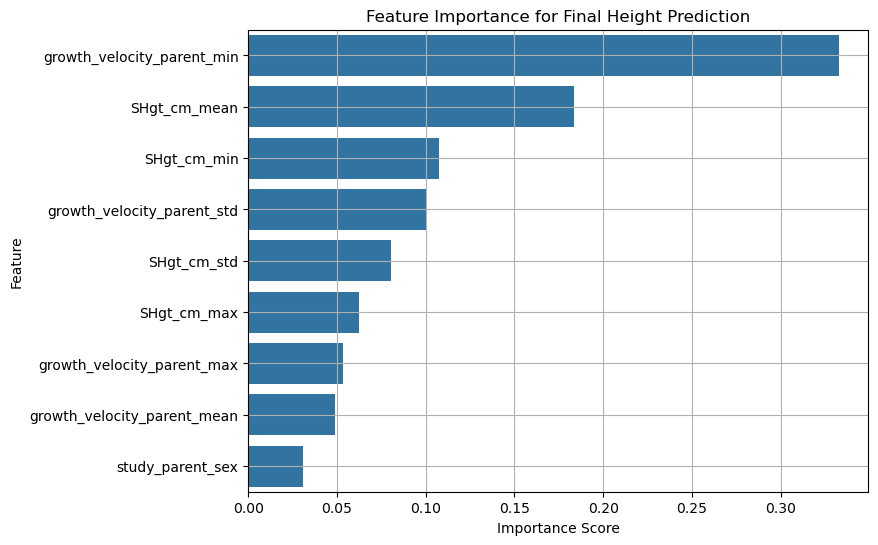

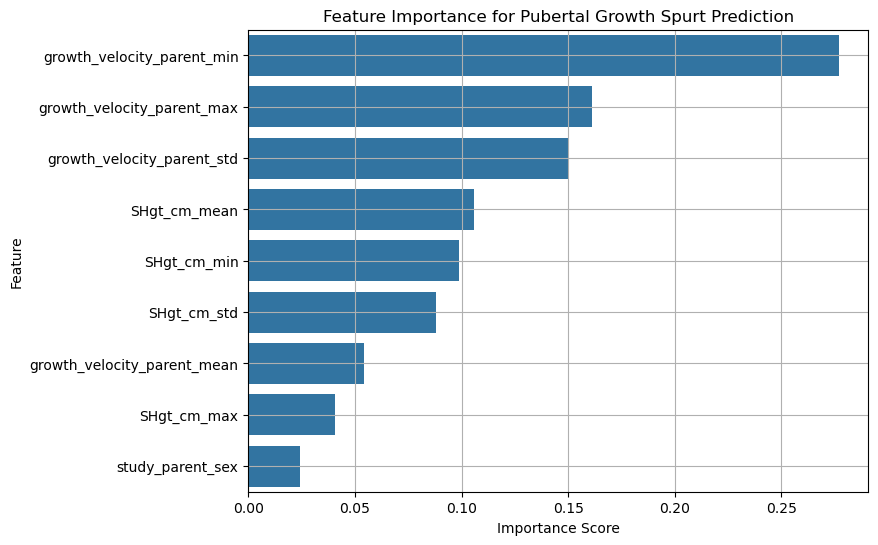

Correlation Analysis - Final Height:


,final_height
final_height,1.000000
pubertal_growth_spurt_magnitude,0.329990
child_sex,0.140233
growth_velocity_parent_mean,0.117957
SHgt_cm_max,0.114437
growth_velocity_parent_max,0.113031
SHgt_cm_mean,0.105508
SHgt_cm_std,0.090786
study_parent_sex,0.064480
parent_sex,0.054664



Correlation Analysis - Pubertal Growth Spurt:


,pubertal_growth_spurt_magnitude
pubertal_growth_spurt_magnitude,1.000000
final_height,0.329990
growth_velocity_parent_std,0.263223
growth_velocity_parent_max,0.209454
SHgt_cm_mean,0.127427
child_sex,0.079216
gen2_id,0.028888
SHgt_cm_std,0.025926
study_parent_sex,0.025233
growth_velocity_parent_mean,0.022727



Hypothesis Testing Results:
T-statistic: -1.1470, P-value: 2.5323e-01
Result: No statistically significant difference → No strong evidence of an impact.


In [91]:
cleaned_data = merged_data.dropna()

# ---- 1. Correlation Analysis ----
correlations = cleaned_data.corr()
final_height_corr = correlations['final_height'].sort_values(ascending=False)
pubertal_growth_corr = correlations['pubertal_growth_spurt_magnitude'].sort_values(ascending=False)

# ---- 2. Visualizations ----

# Scatter Plot: Parent's Mean Height vs. Child's Final Height
plt.figure(figsize=(8,6))
sns.scatterplot(x=cleaned_data['SHgt_cm_mean'], y=cleaned_data['final_height'])
plt.xlabel("Parent's Mean Height (cm)")
plt.ylabel("Child's Final Height (cm)")
plt.title("Relationship Between Parent's Mean Height and Child's Final Height")
plt.grid(True)
plt.show()

# Scatter Plot: Parent's Min Growth Velocity vs. Child's Final Height
plt.figure(figsize=(8,6))
sns.scatterplot(x=cleaned_data['growth_velocity_parent_min'], y=cleaned_data['final_height'])
plt.xlabel("Parent's Minimum Growth Velocity (cm/year)")
plt.ylabel("Child's Final Height (cm)")
plt.title("Influence of Parent's Minimum Growth Velocity on Child's Final Height")
plt.grid(True)
plt.show()

# Distribution of Pubertal Growth Spurts
plt.figure(figsize=(8,6))
sns.histplot(cleaned_data['pubertal_growth_spurt_magnitude'], bins=20, kde=True)
plt.xlabel("Pubertal Growth Spurt Magnitude (cm/year)")
plt.ylabel("Frequency")
plt.title("Distribution of Pubertal Growth Spurt Magnitudes")
plt.grid(True)
plt.show()

# Feature Importance Bar Charts
plt.figure(figsize=(8,6))
sns.barplot(x=feature_importance_final_height_df['Importance'], y=feature_importance_final_height_df['Feature'])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance for Final Height Prediction")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
sns.barplot(x=feature_importance_pubertal_growth_df['Importance'], y=feature_importance_pubertal_growth_df['Feature'])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance for Pubertal Growth Spurt Prediction")
plt.grid(True)
plt.show()

# ---- 3. Hypothesis Testing ----

# Checking if high vs. low parental growth velocity affects final height significantly
median_growth_velocity = cleaned_data['growth_velocity_parent_min'].median()
high_growth_group = cleaned_data[cleaned_data['growth_velocity_parent_min'] >= median_growth_velocity]
low_growth_group = cleaned_data[cleaned_data['growth_velocity_parent_min'] < median_growth_velocity]

t_stat, p_value = ttest_ind(high_growth_group['final_height'], low_growth_group['final_height'])

# Display the correlation analysis results
print("Correlation Analysis - Final Height:")
display(final_height_corr.to_frame())  # Convert to DataFrame and display

print("\nCorrelation Analysis - Pubertal Growth Spurt:")
display(pubertal_growth_corr.to_frame())  # Convert to DataFrame and display

# Display the t-statistic and p-value for hypothesis testing
print("\nHypothesis Testing Results:")
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4e}")

# Interpretation:
if p_value < 0.05:
    print("Result: Statistically significant difference → Parental growth velocity significantly impacts final height.")
else:
    print("Result: No statistically significant difference → No strong evidence of an impact.")
